In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
#import geopandas as gpd
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
import sklearn.linear_model
import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
import time
from keras import models, layers, optimizers, regularizers
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
from statsmodels.tsa.seasonal import seasonal_decompose
import pydot 
import graphviz

In [3]:
raw_df = pd.read_csv("data/Berlin.May18_May19-2.csv")
print(f"The dataset contains {len(raw_df)} Airbnb listings")
pd.set_option('display.max_columns', len(raw_df.columns)) # To view all columns
pd.set_option('display.max_rows', 100)
raw_df.head(3)

The dataset contains 310045 Airbnb listings


Unnamed: 0        Date    id  host_id             neighbourhood   latitude  \
0           0  2018-05-14  2015     2217          Brunnenstr. SÃ¼d  52.534537   
1           1  2018-05-14  2776     3091           Wedding Zentrum  52.552818   
2           2  2018-05-14  3176     3718  Prenzlauer Berg SÃ¼dwest  52.534996   

   longitude        room_type  price  minimum_nights  \
0  13.402557  Entire home/apt     60               5   
1  13.374060     Private room     55               3   
2  13.417579  Entire home/apt     90              62   

   calculated_host_listings_count  
0                               4  
1                               1  
2                               1

In [4]:
raw_df.date = pd.to_datetime(raw_df.Date) 


In [5]:
raw_df.isna().sum()


Unnamed: 0                        0
Date                              0
id                                0
host_id                           0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
calculated_host_listings_count    0
dtype: int64

In [6]:
raw_df.price.value_counts()

30      18572
50      17387
35      16799
40      16367
25      15496
        ...  
402         1
318         1
243         1
294         1
1612        1
Name: price, Length: 410, dtype: int64

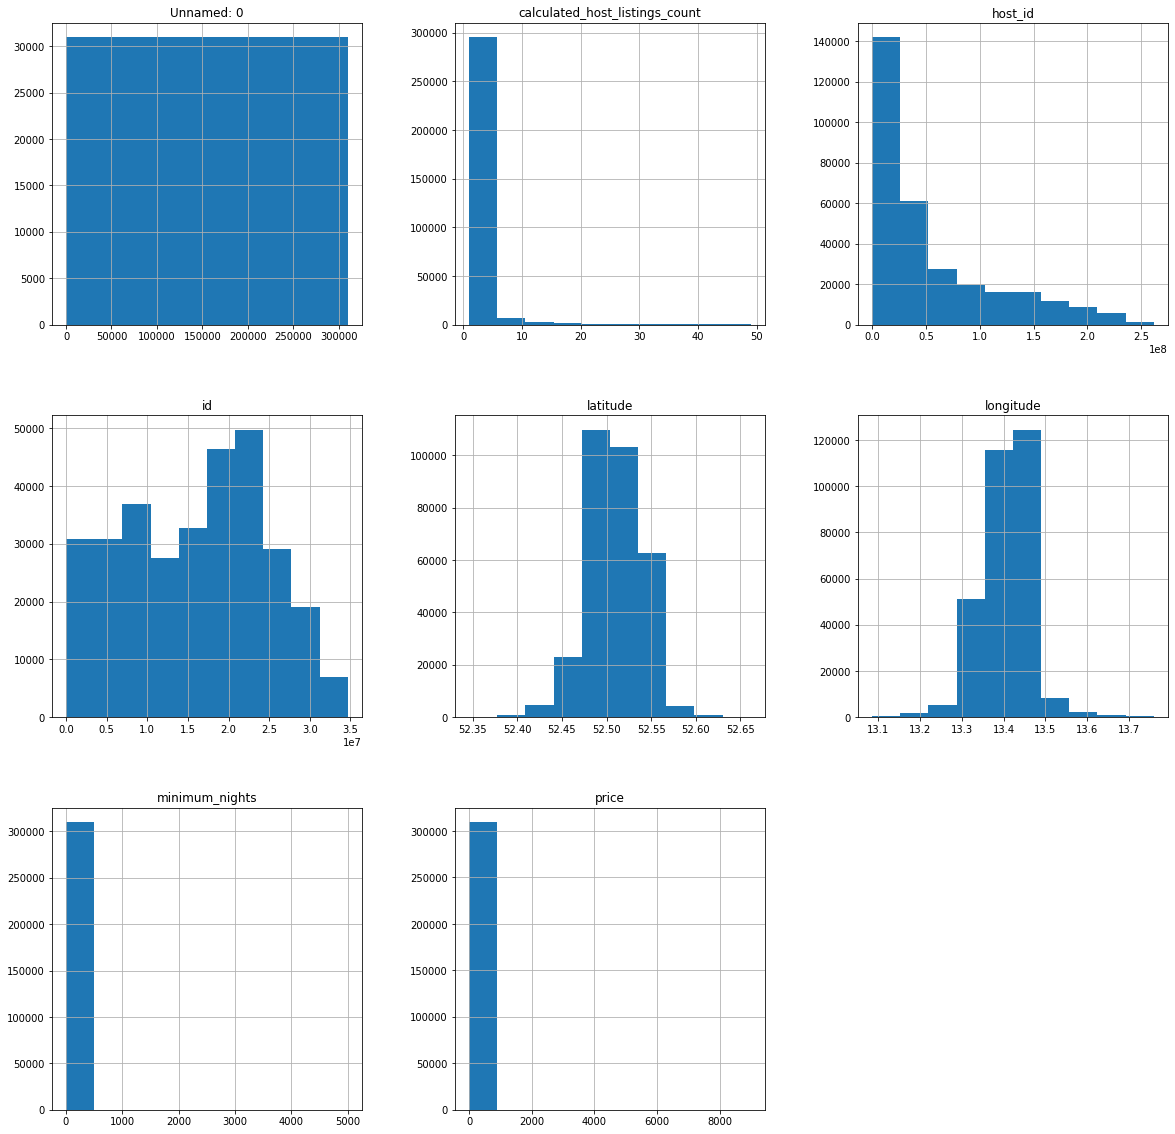

In [7]:
# Replacing columns with f/t with 0/1
raw_df.replace({'f': 0, 't': 1}, inplace=True)

# Plotting the distribution of numerical and boolean categories
raw_df.hist(figsize=(20,20));

In [8]:
raw_df.room_type.value_counts()


Private room       154089
Entire home/apt    152075
Shared room          3881
Name: room_type, dtype: int64

In [9]:

raw_df['Date']=pd.to_datetime(raw_df['Date'])

raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310045 entries, 0 to 310044
Data columns (total 11 columns):
Unnamed: 0                        310045 non-null int64
Date                              310045 non-null datetime64[ns]
id                                310045 non-null int64
host_id                           310045 non-null int64
neighbourhood                     310045 non-null object
latitude                          310045 non-null float64
longitude                         310045 non-null float64
room_type                         310045 non-null object
price                             310045 non-null int64
minimum_nights                    310045 non-null int64
calculated_host_listings_count    310045 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(6), object(2)
memory usage: 26.0+ MB


In [10]:
print("Mean nightly price of listings in each year on Airbnb in NYC:")
print(round(raw_df.set_index('Date').price.resample('YS').mean(),2))

Mean nightly price of listings in each year on Airbnb in NYC:
Date
2018-01-01    64.03
2019-01-01    68.45
Freq: AS-JAN, Name: price, dtype: float64


In [11]:
host_listings_count = raw_df.host_id.value_counts()
host_listings_count

1625771      576
8250486      559
2293972      344
59442407     311
54942921     291
            ... 
83555030       1
56107463       1
151396792      1
4378918        1
176762918      1
Name: host_id, Length: 33263, dtype: int64

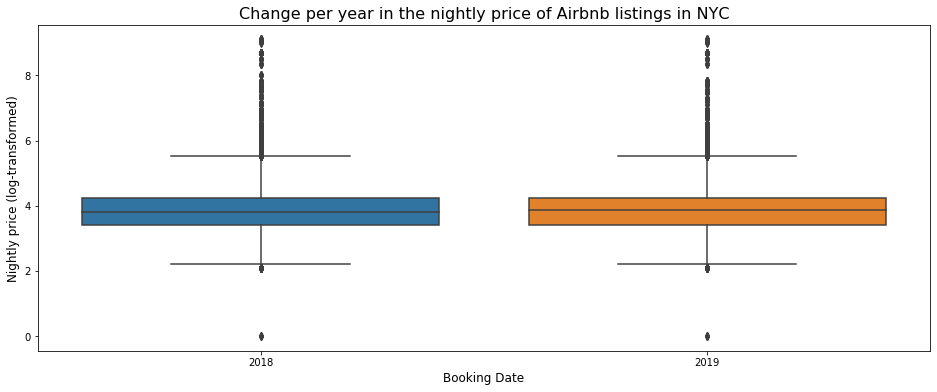

In [12]:
plt.figure(figsize=(16,6))
sns.boxplot(raw_df.date.dt.year, np.log(raw_df.price))
plt.xlabel('Booking Date', fontsize=12)
plt.ylabel('Nightly price (log-transformed)', fontsize=12)
plt.title('Change per year in the nightly price of Airbnb listings in NYC', fontsize=16)
plt.show()

In [13]:
raw_df.describe()

Unnamed: 0            id       host_id       latitude  \
count  310045.000000  3.100450e+05  3.100450e+05  310045.000000   
mean   155022.000000  1.585938e+07  5.427480e+07      52.509928   
std     89502.426443  8.726161e+06  5.884526e+07       0.030847   
min         0.000000  1.944000e+03  1.581000e+03      52.345800   
25%     77511.000000  8.117216e+06  9.283428e+06      52.489105   
50%    155022.000000  1.695407e+07  3.116870e+07      52.509191   
75%    232533.000000  2.252765e+07  8.085311e+07      52.532790   
max    310044.000000  3.468232e+07  2.616142e+08      52.661777   

           longitude          price  minimum_nights  \
count  310045.000000  310045.000000   310045.000000   
mean       13.406469      65.708310        6.440855   
std         0.057800     194.826501       34.562326   
min        13.084926       0.000000        1.000000   
25%        13.376240      30.000000        2.000000   
50%        13.417036      46.000000        2.000000   
75%        13.439459      70.000000        4.000000   
max        13.760330    9000.000000     5000.000000   

       calculated_host_listings_count  
count                   310045.000000  
mean                         1.927588  
std                          3.771041  
min                          1.000000  
25%                          1.000000  
50%                          1.000000  
75%                          1.000000  
max                         49.000000

In [14]:
print(f"Nightly advertised prices range from ${min(raw_df.price)} to ${max(raw_df.price)}.")


Nightly advertised prices range from $0 to $9000.


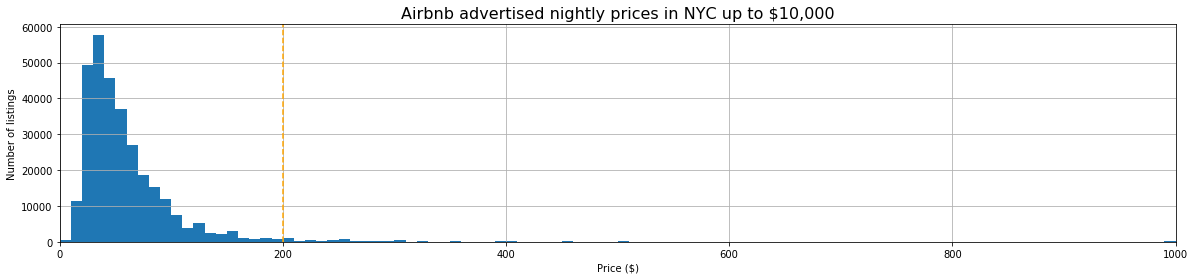

In [15]:
# Distribution of prices from $0 to $1000
plt.figure(figsize=(20,4))
raw_df.price.hist(bins=100, range=(0,1000))
plt.margins(x=0)
plt.axvline(200, color='orange', linestyle='--')
plt.title("Airbnb advertised nightly prices in NYC up to $10,000", fontsize=16)
plt.xlabel("Price ($)")
plt.ylabel("Number of listings")
plt.show()

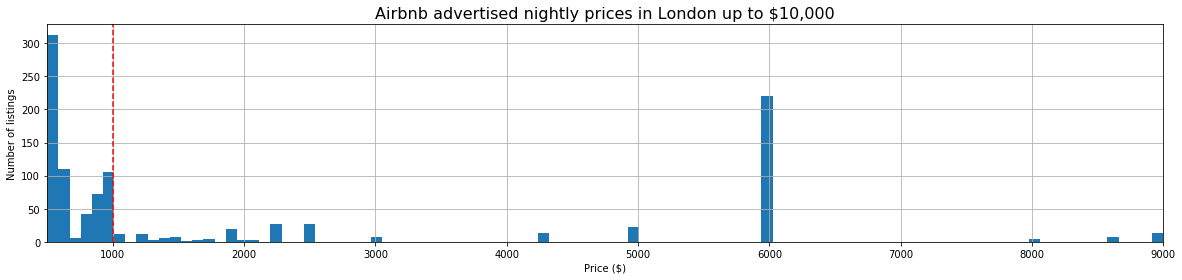

In [16]:
# Distribution of prices from $500 upwards
plt.figure(figsize=(20,4))
raw_df.price.hist(bins=100, range=(500, max(raw_df.price)))
plt.margins(x=0)
plt.axvline(500, color='orange', linestyle='--')
plt.axvline(1000, color='red', linestyle='--')
plt.title("Airbnb advertised nightly prices in London up to $10,000", fontsize=16)
plt.xlabel("Price ($)")
plt.ylabel("Number of listings")
plt.show()

In [17]:
def category_count_plot(col, figsize=(8,4)):
    """
    Plots a simple bar chart of the total count for each category in the column specified.
    A figure size can optionally be specified.
    """
    plt.figure(figsize=figsize)
    raw_df[col].value_counts().plot(kind='bar')
    plt.title(col)
    plt.xticks(rotation=0)
    plt.show()

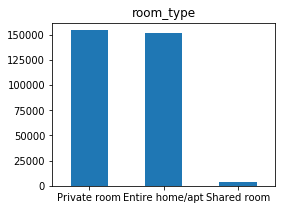

Private room       0.496989
Entire home/apt    0.490493
Shared room        0.012518
Name: room_type, dtype: float64


In [18]:
for col in ['room_type']:
    category_count_plot(col, figsize=(4,3))
    print(raw_df[col].value_counts(normalize=True))

In [19]:
transformed_df = pd.get_dummies(raw_df)

In [20]:
def multi_collinearity_heatmap(df, figsize=(11,9)):
    
    """
    Creates a heatmap of correlations between features in the df. A figure size can optionally be set.
    """
    
    # Set the style of the visualization
    sns.set(style="white")

    # Create a covariance matrix
    corr = df.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max());

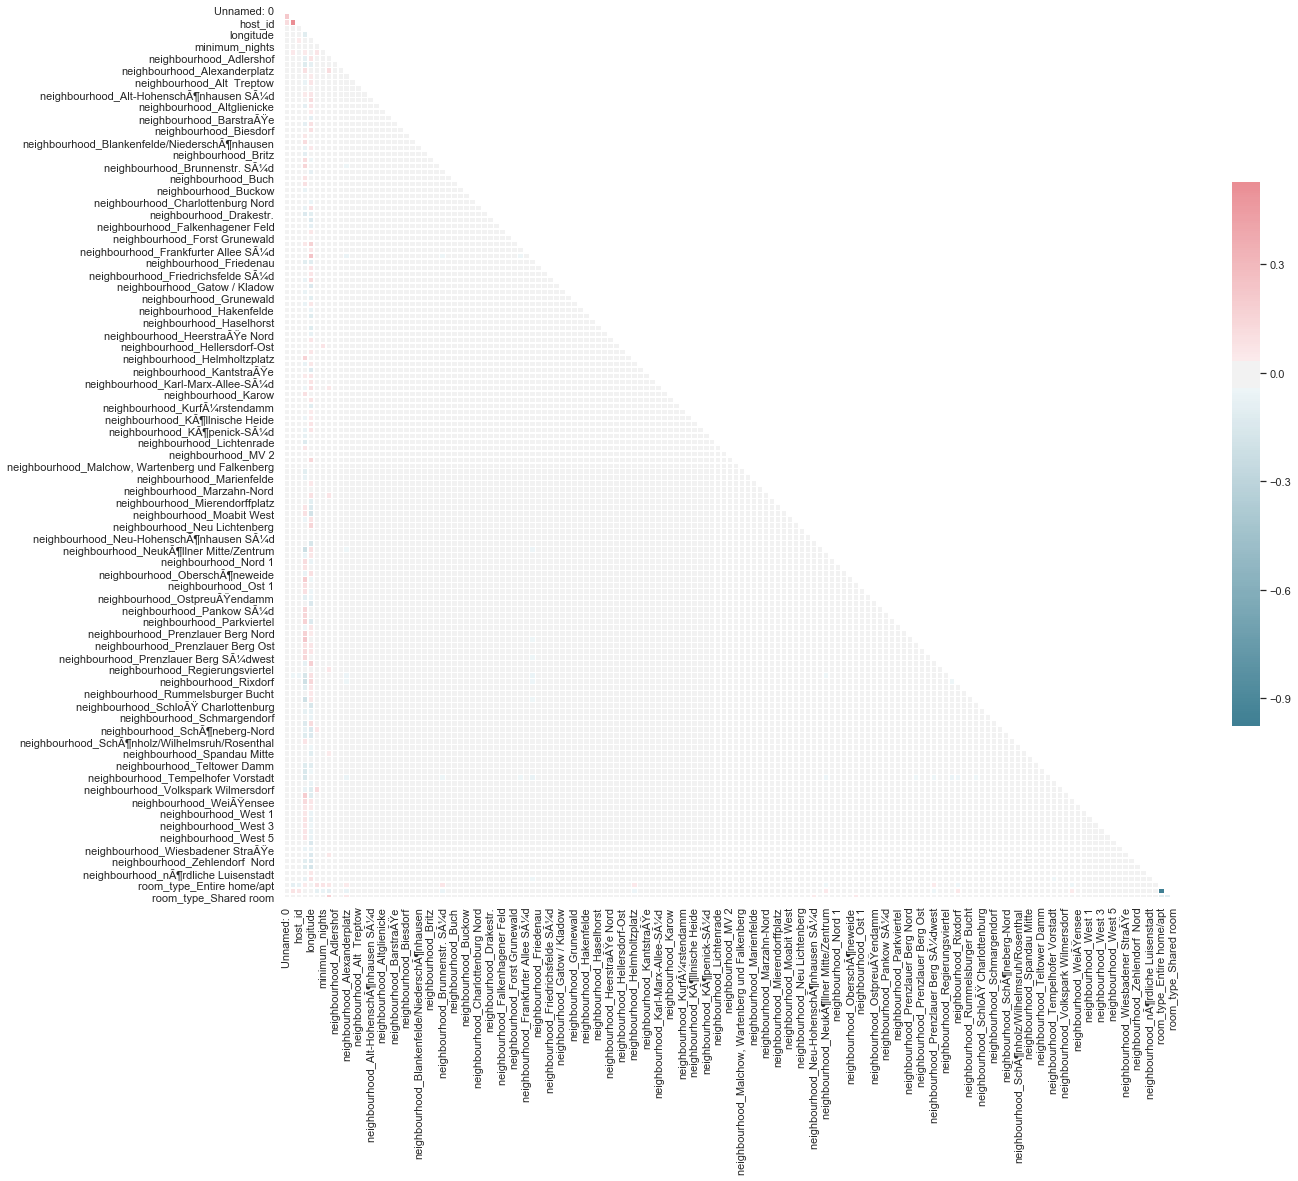

In [21]:
multi_collinearity_heatmap(transformed_df, figsize=(20,20))

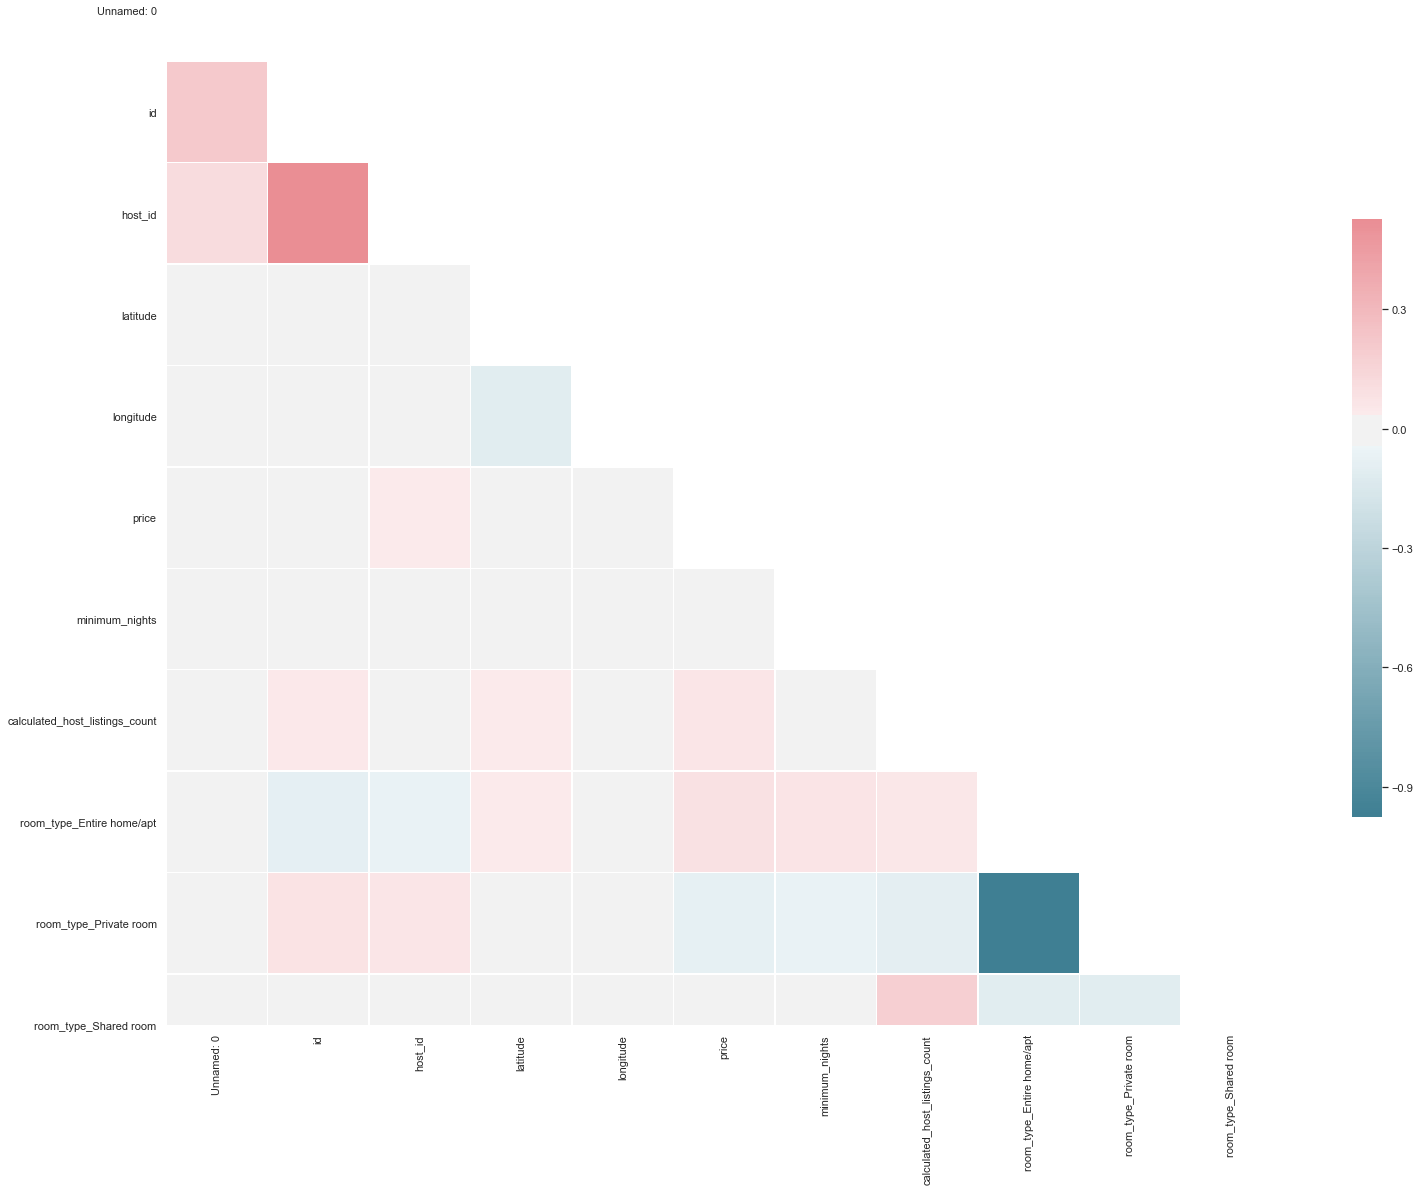

In [22]:
multi_collinearity_heatmap(transformed_df.drop(list(transformed_df.columns[transformed_df.columns.str.startswith('neighbourhood')]), axis=1), figsize=(25,22))

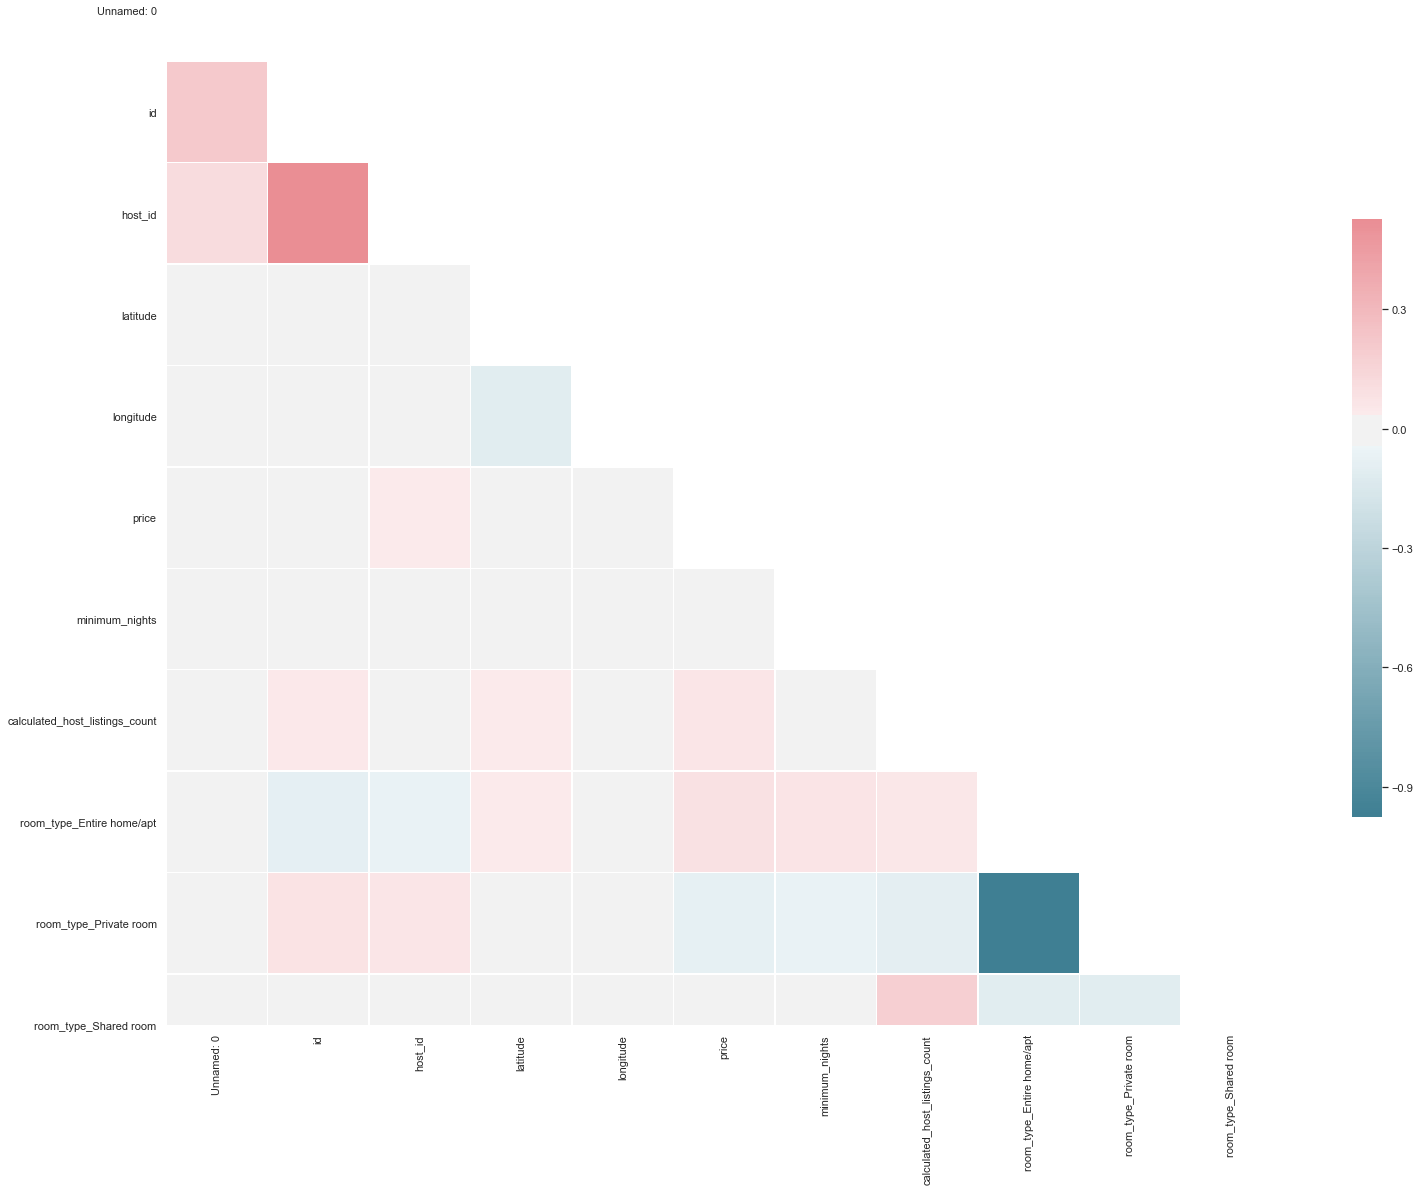

In [23]:
# Final assessment of multi-collinearity
multi_collinearity_heatmap(transformed_df.drop(list(transformed_df.columns[transformed_df.columns.str.startswith('neighbourhood')]), axis=1), figsize=(25,22))

In [24]:
numerical_columns = ['price', 'id', 'calculated_host_listings_count', 'minimum_nights']


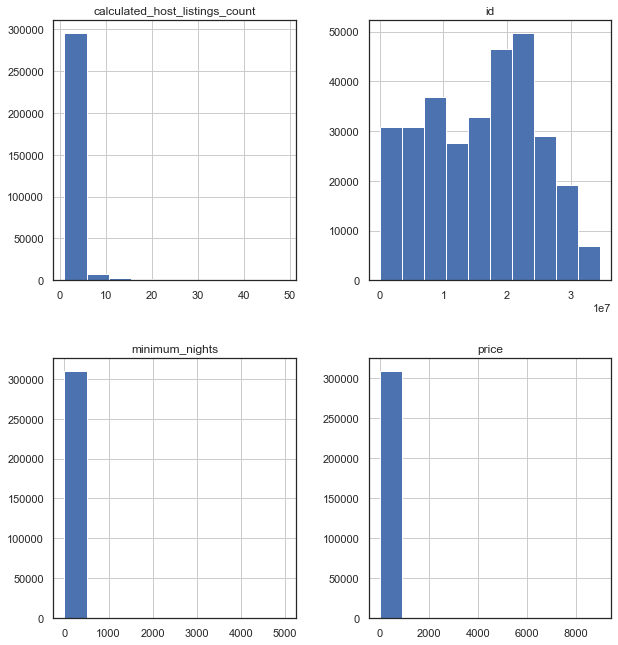

In [25]:
transformed_df[numerical_columns].hist(figsize=(10,11));

In [40]:
transformed_df['Date'] = pd.to_datetime(transformed_df['Date'])
transformed_df['day_of_week'] = transformed_df['Date'].dt.day_name().map({"Monday":0, "Tuesday":1,"Wednesday":2,"Thursday":3,"Friday":4,"Saturday":5,"Sunday":6})


In [41]:
transformed_df["new_year_day"] = transformed_df['Date'].apply(lambda x: pd.Timestamp(year=x.year, month=1, day=1))
transformed_df['day_of_the_year'] = transformed_df.apply(lambda x: (x['Date'] - x['new_year_day']).days + 1, axis=1)

In [42]:
transformed_df.tail(40)

Unnamed: 0       Date        id    host_id  latitude  ...  \
310005      310005 2019-05-14  34637714   33821412  52.46791  ...   
310006      310006 2019-05-14  34638322   14227798  52.48444  ...   
310007      310007 2019-05-14  34638507  135973057  52.48889  ...   
310008      310008 2019-05-14  34638864   14098285  52.51841  ...   
310009      310009 2019-05-14  34639457  251497729  52.48285  ...   
310010      310010 2019-05-14  34642923  138658157  52.47500  ...   
310011      310011 2019-05-14  34644413  245041680  52.49583  ...   
310012      310012 2019-05-14  34644792  261366620  52.49898  ...   
310013      310013 2019-05-14  34644971   68063826  52.50700  ...   
310014      310014 2019-05-14  34645633  178494220  52.51781  ...   
310015      310015 2019-05-14  34646313   97457092  52.46979  ...   
310016      310016 2019-05-14  34646939  261382073  52.51478  ...   
310017      310017 2019-05-14  34647288  199624438  52.52187  ...   
310018      310018 2019-05-14  34647786  258036843  52.53656  ...   
310019      310019 2019-05-14  34660474   38488471  52.53573  ...   
310020      310020 2019-05-14  34661178   62816407  52.49562  ...   
310021      310021 2019-05-14  34661358  219651637  52.40992  ...   
310022      310022 2019-05-14  34662390   26413652  52.49027  ...   
310023      310023 2019-05-14  34663347  129018052  52.54880  ...   
310024      310024 2019-05-14  34663542  261505612  52.51124  ...   
310025      310025 2019-05-14  34664686    6519019  52.53476  ...   
310026      310026 2019-05-14  34666308   43279092  52.45420  ...   
310027      310027 2019-05-14  34666919  195122046  52.48707  ...   
310028      310028 2019-05-14  34669033   84060429  52.53135  ...   
310029      310029 2019-05-14  34669043  188849025  52.50797  ...   
310030      310030 2019-05-14  34671107  156028691  52.55136  ...   
310031      310031 2019-05-14  34672106    5034211  52.63786  ...   
310032      310032 2019-05-14  34672629  150465250  52.47889  ...   
310033      310033 2019-05-14  34673672  177583779  52.42852  ...   
310034      310034 2019-05-14  34674496   95227599  52.48347  ...   
310035      310035 2019-05-14  34675305  151407333  52.52829  ...   
310036      310036 2019-05-14  34676358   37884755  52.49580  ...   
310037      310037 2019-05-14  34676655   18569702  52.48034  ...   
310038      310038 2019-05-14  34677150   23794332  52.43749  ...   
310039      310039 2019-05-14  34677601  261592052  52.48740  ...   
310040      310040 2019-05-14  34678365  222154123  52.42278  ...   
310041      310041 2019-05-14  34681094  261614182  52.63020  ...   
310042      310042 2019-05-14  34681403   19220411  52.45402  ...   
310043      310043 2019-05-14  34681413  261605200  52.47342  ...   
310044      310044 2019-05-14  34682315  204800048  52.54929  ...   

        room_type_Private room  room_type_Shared room  day_of_week  \
310005                       1                      0            1   
310006                       1                      0            1   
310007                       1                      0            1   
310008                       1                      0            1   
310009                       0                      0            1   
310010                       1                      0            1   
310011                       0                      0            1   
310012                       0                      0            1   
310013                       0                      0            1   
310014                       1                      0            1   
310015                       1                      0            1   
310016                       1                      0            1   
310017                       0                      0            1   
310018                       0                      0            1   
310019                       1                      0            1   
310020                       0                      0     

In [43]:
# Separating X and y
X = transformed_df.drop('price', axis=1)
y = transformed_df.price

# Scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X.drop(["Date", "new_year_day"], axis=1)),columns=X.drop(["Date", "new_year_day"], axis=1).columns)

In [44]:
X.head()

Unnamed: 0        id   host_id  latitude  longitude  ...  \
0   -1.732045 -1.817224 -0.922295  0.797800  -0.067680  ...   
1   -1.732034 -1.817137 -0.922280  1.390419  -0.560708  ...   
2   -1.732023 -1.817091 -0.922269  0.812676   0.192211  ...   
3   -1.732012 -1.817075 -0.922262 -0.358956  -0.993153  ...   
4   -1.732001 -1.816644 -0.922037  1.077243   0.149174  ...   

   room_type_Entire home/apt  room_type_Private room  room_type_Shared room  \
0                   1.019198               -0.993996              -0.112589   
1                  -0.981164                1.006040              -0.112589   
2                   1.019198               -0.993996              -0.112589   
3                  -0.981164                1.006040              -0.112589   
4                  -0.981164                1.006040              -0.112589   

   day_of_week  day_of_the_year  
0    -1.180544        -0.379482  
1    -1.180544        -0.379482  
2    -1.180544        -0.379482  
3    -1.180544        -0.379482  
4    -1.180544        -0.379482  

[5 rows x 150 columns]

In [45]:
# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [46]:
# MOST SUCCESSFUL MODEL
xgb_reg_start = time.time()

xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))

Time taken to run: 1.9 minutes

Training MSE: 1587.4136
Validation MSE: 3443.7198

Training r2: 0.9572
Validation r2: 0.9166


In [47]:
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', inplace=True)
ft_weights_xgb_reg.tail()

weight
day_of_week                          0.024436
host_id                              0.024669
room_type_Entire home/apt            0.054906
neighbourhood_SchÃ¶neberg-Nord       0.108022
neighbourhood_Volkspark Wilmersdorf  0.633402

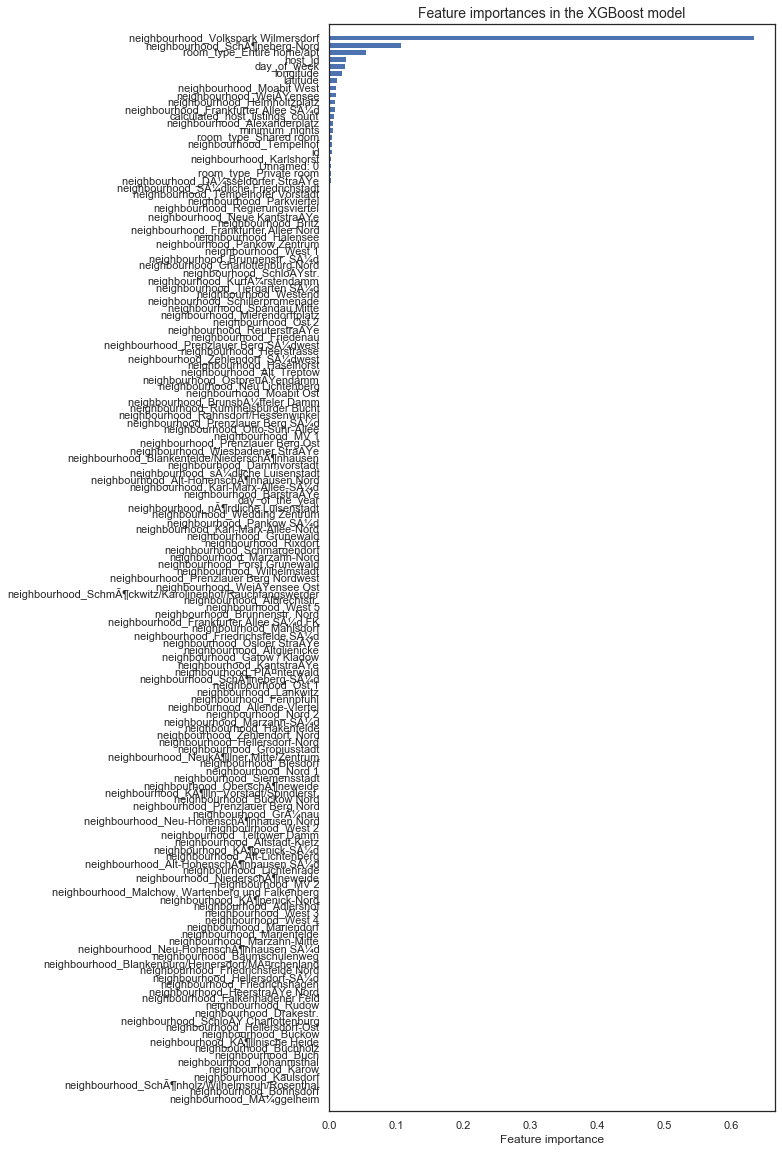

In [48]:
# Plotting feature importances
plt.figure(figsize=(8,20))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

In [49]:
print("Median number of listings per host:", int(raw_df.calculated_host_listings_count.median()))
print("Mean number of listings per host:", int(round(raw_df.calculated_host_listings_count.mean())))
print(f"{int(round(100*len(raw_df[raw_df.calculated_host_listings_count == 1])/len(raw_df)))}% of listings are from hosts with one listing.")

Median number of listings per host: 1
Mean number of listings per host: 2
76% of listings are from hosts with one listing.


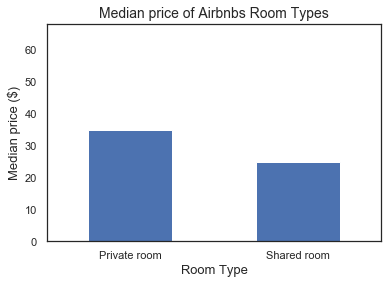

In [55]:
raw_df.groupby('room_type').price.median().plot(kind='bar')
plt.title('Median price of Airbnbs Room Types', fontsize=14)
plt.xlabel('Room Type', fontsize=13)
plt.ylabel('Median price ($)', fontsize=13)
plt.xticks(rotation=0)
plt.xlim(left=0.5)
plt.show()

Text(0, 0.5, 'Median price ($)')

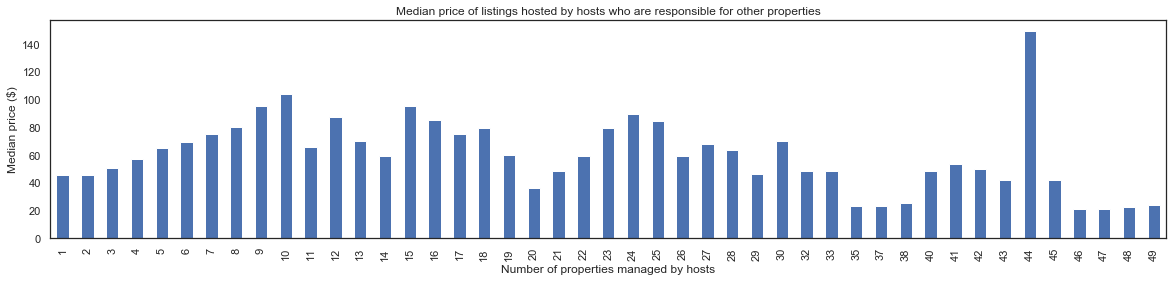

In [57]:
# Median price for different host listing counts
plt.figure()
raw_df.groupby('calculated_host_listings_count').price.median().plot(figsize=(20,4), kind='bar')
plt.title('Median price of listings hosted by hosts who are responsible for other properties')
plt.xlabel('Number of properties managed by hosts')
plt.ylabel('Median price ($)')

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 128)               19328     
_________________________________________________________________
dense_21 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_22 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 257       
Total params: 118,401
Trainable params: 118,401
Non-trainable params: 0
_________________________________________________________________
None


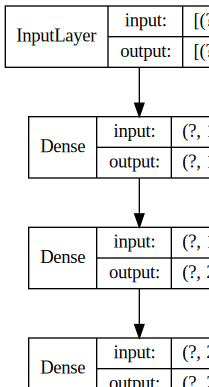

In [61]:
# Building the model
nn2 = models.Sequential()
nn2.add(layers.Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
nn2.add(layers.Dense(256, activation='relu'))
nn2.add(layers.Dense(256, activation='relu'))
nn2.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn2.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Model summary
print(nn2.summary())

# Visualising the neural network
SVG(model_to_dot(nn2, show_layer_names=False, show_shapes=True).create(prog='dot', format='svg'))

In [59]:
# Training the model
nn2_start = time.time()

nn2_history = nn2.fit(X_train,
                  y_train,
                  epochs=100,
                  batch_size=256,
                  validation_split = 0.1)

nn2_end = time.time()

print(f"Time taken to run: {round((nn2_end - nn2_start)/60,1)} minutes")

Epoch 1/100
872/872 [==============================] - 8s 9ms/step - loss: 29424.1680 - mean_squared_error: 29424.1680 - val_loss: 16593.2734 - val_mean_squared_error: 16593.2734
Epoch 2/100
872/872 [==============================] - 6s 7ms/step - loss: 12721.5762 - mean_squared_error: 12721.5762 - val_loss: 13483.4863 - val_mean_squared_error: 13483.4863
Epoch 3/100
872/872 [==============================] - 6s 7ms/step - loss: 11522.1475 - mean_squared_error: 11522.1475 - val_loss: 13278.3652 - val_mean_squared_error: 13278.3652
Epoch 4/100
872/872 [==============================] - 7s 8ms/step - loss: 11386.6631 - mean_squared_error: 11386.6631 - val_loss: 13029.5732 - val_mean_squared_error: 13029.5732
Epoch 5/100
872/872 [==============================] - 7s 8ms/step - loss: 11091.4326 - mean_squared_error: 11091.4326 - val_loss: 13089.7354 - val_mean_squared_error: 13089.7354
Epoch 6/100
872/872 [==============================] - 7s 8ms/step - loss: 10804.6562 - mean_squared_erro

In [72]:
def nn_model_evaluation(model, skip_epochs=0, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    """
    For a given neural network model that has already been fit, prints for the train and tests sets the MSE and r squared
    values, a line graph of the loss in each epoch, and a scatterplot of predicted vs. actual values with a line
    representing where predicted = actual values. Optionally, a value for skip_epoch can be provided, which skips that
    number of epochs in the line graph of losses (useful in cases where the loss in the first epoch is orders of magnitude
    larger than subsequent epochs). Training and test sets can also optionally be specified.
    """

    # MSE and r squared values
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    print("Training MSE:", round(mean_squared_error(y_train, y_train_pred),4))
    print("Validation MSE:", round(mean_squared_error(y_test, y_test_pred),4))
    print("\nTraining r2:", round(r2_score(y_train, y_train_pred),4))
    print("Validation r2:", round(r2_score(y_test, y_test_pred),4))
    
    # Line graph of losses
    model_results = model.history.history
    plt.plot(list(range((skip_epochs+1),len(model_results['loss'])+1)), model_results['loss'][skip_epochs:], label='Train')
    plt.plot(list(range((skip_epochs+1),len(model_results['val_loss'])+1)), model_results['val_loss'][skip_epochs:], label='Test', color='green')
    plt.legend()
    plt.title('Training and test loss at each epoch', fontsize=14)
    plt.show()
    
    # Scatterplot of predicted vs. actual values
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle('Predicted vs. actual values', fontsize=14, y=1)
    plt.subplots_adjust(top=0.93, wspace=0)
    
    ax1.scatter(y_test, y_test_pred, s=2, alpha=0.7)
    ax1.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
    ax1.set_title('Test set')
    ax1.set_xlabel('Actual values')
    ax1.set_ylabel('Predicted values')
    
    ax2.scatter(y_train, y_train_pred, s=2, alpha=0.7)
    ax2.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
    ax2.set_title('Train set')
    ax2.set_xlabel('Actual values')
    ax2.set_ylabel('')
    ax2.set_yticklabels(labels='')
    
    plt.show()

In [73]:
#nn_model_evaluation(nn2)


Training MSE: 41444.9476
Validation MSE: 45643.5594

Training r2: -0.1164
Validation r2: -0.1054


KeyError: 'loss'

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 128)               19328     
_________________________________________________________________
dense_35 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_36 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_37 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 513       
Total params: 250,241
Trainable params: 250,241
Non-trainable params: 0
_________________________________________________________________
None


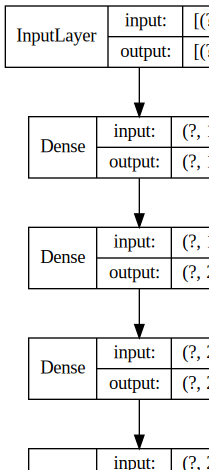

In [74]:
# Building the model
nn3 = models.Sequential()
nn3.add(layers.Dense(128, input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn3.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn3.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn3.add(layers.Dense(512, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn3.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn3.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Model summary
print(nn3.summary())

# Visualising the neural network
SVG(model_to_dot(nn3, show_layer_names=False, show_shapes=True).create(prog='dot', format='svg'))

In [76]:
# Training the model
nn3_start = time.time()

nn3_history = nn3.fit(X_train,
                  y_train,
                  epochs=15,
                  batch_size=256,
                  validation_split = 0.1)

nn3_end = time.time()

print(f"Time taken to run: {round((nn3_end - nn3_start)/60,1)} minutes")


Epoch 1/15
872/872 [==============================] - 9s 11ms/step - loss: 7408.9146 - mean_squared_error: 7342.8345 - val_loss: 8761.3135 - val_mean_squared_error: 8694.8037
Epoch 2/15
872/872 [==============================] - 9s 10ms/step - loss: 7570.9839 - mean_squared_error: 7504.8394 - val_loss: 8382.2100 - val_mean_squared_error: 8316.3672
Epoch 3/15
872/872 [==============================] - 9s 10ms/step - loss: 7287.0400 - mean_squared_error: 7221.7046 - val_loss: 8735.0293 - val_mean_squared_error: 8670.1387
Epoch 4/15
872/872 [==============================] - 10s 11ms/step - loss: 7011.8696 - mean_squared_error: 6946.6772 - val_loss: 8874.6631 - val_mean_squared_error: 8809.4980
Epoch 5/15
872/872 [==============================] - 10s 11ms/step - loss: 6780.3481 - mean_squared_error: 6715.3359 - val_loss: 8718.0586 - val_mean_squared_error: 8653.3809
Epoch 6/15
872/872 [==============================] - 10s 12ms/step - loss: 6673.2178 - mean_squared_error: 6608.1646 - val

In [ ]:
# Evaluating the model
nn_model_evaluation(nn3, skip_epochs=2)

In [ ]:
# Building the model
nn4 = models.Sequential()
nn4.add(layers.Dense(128, input_shape=(X_train.shape[1],), kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn4.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn4.add(layers.Dense(256, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn4.add(layers.Dense(512, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
nn4.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn4.compile(loss='mean_squared_error',
            optimizer='SGD',
            metrics=['mean_squared_error'])

# Model summary
print(nn4.summary())

# Visualising the neural network
SVG(model_to_dot(nn4, show_layer_names=False, show_shapes=True).create(prog='dot', format='svg'))

In [68]:
# Training the model
nn4_start = time.time()

nn4_history = nn4.fit(X_train,
                  y_train,
                  epochs=15,
                  batch_size=256,
                  validation_split = 0.1)

nn4_end = time.time()

print(f"Time taken to run: {round((nn4_end - nn4_start)/60,1)} minutes")

Epoch 1/15
872/872 [==============================] - 12s 14ms/step - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 2/15
872/872 [==============================] - 11s 13ms/step - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 3/15
872/872 [==============================] - 11s 13ms/step - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 4/15
872/872 [==============================] - 10s 12ms/step - loss: nan - mean_squared_error: nan - val_loss: nan - val_mean_squared_error: nan
Epoch 5/15
723/872 [=======================>......] - ETA: 1s - loss: nan - mean_squared_error: nan

KeyboardInterrupt: 

In [64]:
nn_model_evaluation(nn4, skip_epochs=10) # This model took several epochs before the loss was in a similar range to other models

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

In [65]:
nn5 = models.Sequential()
nn5.add(layers.Dropout(0.5, input_shape=(X_train.shape[1],)))
nn5.add(layers.Dense(128, activation='relu'))
nn5.add(layers.Dropout(0.5))
nn5.add(layers.Dense(256, activation='relu'))
nn5.add(layers.Dropout(0.5))
nn5.add(layers.Dense(512, activation='relu'))
nn5.add(layers.Dropout(0.5))
nn5.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn5.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Model summary
print(nn5.summary())

# Visualising the neural network
SVG(model_to_dot(nn5, show_layer_names=False, show_shapes=True).create(prog='dot', format='svg'))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 150)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               19328     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)               131584    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)              

AttributeError: 'NoneType' object has no attribute 'create'

In [66]:
# Training the model
nn5_start = time.time()

nn5_history = nn5.fit(X_train,
                  y_train,
                  epochs=15,
                  batch_size=256,
                  validation_split = 0.1)

nn5_end = time.time()

print(f"Time taken to run: {round((nn5_end - nn5_start)/60,1)} minutes")

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

In [67]:
nn_model_evaluation(nn5, skip_epochs=2)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

In [68]:
nn6 = models.Sequential()
nn6.add(layers.Dropout(0.2, input_shape=(X_train.shape[1],)))
nn6.add(layers.Dense(128, activation='relu'))
nn6.add(layers.Dropout(0.2))
nn6.add(layers.Dense(256, activation='relu'))
nn6.add(layers.Dropout(0.2))
nn6.add(layers.Dense(512, activation='relu'))
nn6.add(layers.Dropout(0.2))
nn6.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn6.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Model summary
print(nn6.summary())

# Visualising the neural network
SVG(model_to_dot(nn6, show_layer_names=False, show_shapes=True).create(prog='dot', format='svg'))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_4 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               19328     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 512)               131584    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)              

AttributeError: 'NoneType' object has no attribute 'create'

In [69]:
# Training the model
nn6_start = time.time()

nn6_history = nn6.fit(X_train,
                  y_train,
                  epochs=15,
                  batch_size=512,
                  validation_split = 0.1)

nn6_end = time.time()

print(f"Time taken to run: {round((nn6_end - nn6_start)/60,1)} minutes")

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

In [70]:
nn_model_evaluation(nn6)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).